<a href="https://colab.research.google.com/github/ShreyaaChauhan/Deep_Learning_with_Pytorch/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with pytorch


# 1. Make classification data and get it ready

In [8]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, Y = make_circles(n_samples, noise = 0.03, random_state = 42)

In [9]:
len(X), len(Y)

(1000, 1000)

In [10]:
# Make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": Y})

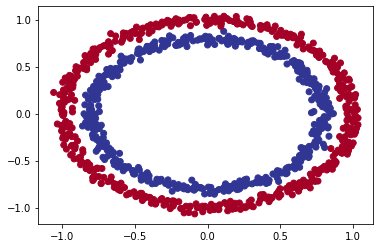

In [11]:
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0],
            y = X[:,1],
            c= Y,
            cmap =plt.cm.RdYlBu)

# Chack inputs and output shapes 

In [12]:
X.shape, Y.shape

((1000, 2), (1000,))

# Turn Data into tensors and create train and splits

In [13]:
# import libraries
import torch
from torch import nn 
from torch.nn.modules.loss import BCEWithLogitsLoss

In [14]:
X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.float)

In [15]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [16]:
len(X_train), len(X_test), len(Y_train), len(Y_test)

(800, 200, 800, 200)

# Building a model 


TODO:
1. Setup device agonistic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [17]:
# seting up device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"

1. Subclasses nn.Module (almost all models in Pytorch subclass nn.Module)
2. Create nn.Linear() layer thata re capable of handling the shapes of our data
3. Define a forward() method that outlines the forward pass (or forwards coumputation) of the model
4. Instantiate an instance of our model class and sent it to the target device

In [18]:
# construct a model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # Create 2 linear layers capable of handling the shapes of data
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)
  # Defiine a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
# Make Predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{Y_test[:10]}")



Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.6980],
        [-0.6687],
        [-0.5455],
        [-0.7421],
        [-0.1814],
        [-0.1663],
        [-0.3723],
        [-0.2538],
        [-0.5611],
        [-0.6627]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])



# Setup loss function and optimizer
which loss function and optimizer should you use?(problem specific)

for example for regression you might want MAE or MSE (mean absolute eroor or mearn squared eroor)

for classification you might want binary cross entropy or categorical cross entropy (cross entropy)

As a reminder, the loss function measures how **wrong** our model predictions are. 

And of optimizers, two of the most common and useful are SGD and Adam, however Pytorch has many buildt- in pd.options

* for the loss function we're going to use `torch.nn.BCEWithLogitsLoss`

In [21]:
# Setuo the loss function
#loss_fn - nn.BCELoss() # BCELoss = requires inouts to have gone through the sigmoid activation prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [22]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

# Train Model

PyTorch training loop steps

1. **Forward pass** The model goes through all of the training data once, performing its `forward()` function calculations(model(X_train))

2. **Calculate the loss** The model's output (predictions) are compared to the ground truth and evaluated to see how wrong they are `(loss = loss_fn(y_pred, y_train))`

3. **Zero gradients** The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step `optimizer.zero_grad()`

4. **Perform backpropagation on the loss** Computes the gradient of the loss with respect for every model parameters to be updated (each parameter with `requires_grad = True`) This is known as **backpropagation** hence "backwards" (`loss.backward()`)

5. **Step the optimizer(gradient descent)** Update the parameters with `requires_grad = True` with respect to the loss gradient in order to improve them (`optimizer.step()`)


# Going from raw logits -> prediction probabiliteies -> prediction labels
Our model outputs are going to be raw **logits**

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g sigmoid for binary classification and softmax for multiclass classification). 

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [23]:
# view the first 5 outputs of the forward pass on the test daya
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.6980],
        [-0.6687],
        [-0.5455],
        [-0.7421],
        [-0.1814]], device='cuda:0')

In [24]:
# use the sigmoid activation function on our model logits to turn them into prediction probabilities 
y_pred_probs = torch.sigmoid(y_logits)
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [25]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

# Building a training and testing loop 

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data to target device
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

# Building training and evaluation loop
for epoch in range(epochs):
  # Training
  model_0.train()

  # Forward pass 
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # Calculate loss/accoracy
  #loss = loss_fn(torch.sigmoid(y_logits), Y_train) # nn.BCELoss expects prediction probabilities as input
  loss = loss_fn(y_logits, Y_train) # nn.BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true =Y_train, y_pred =y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # loss backward (backpropagation)
  loss.backward()

  # optimizer step (gradient descent)
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    # Forward pass 
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate test loss/acc
    test_loss = loss_fn(test_logits, Y_test)
    test_acc = accuracy_fn(y_true = Y_test, y_pred = test_pred)

    #print out what's happenin
    if epoch % 10 ==0:
      print(f"Epoch : {epoch} | Loss: {loss: .5f}, Acc: {acc: .2f} | Test loss: {test_loss: .2f}")
  


Epoch : 0 | Loss:  0.72407, Acc:  50.00 | Test loss:  0.72
Epoch : 10 | Loss:  0.70798, Acc:  41.88 | Test loss:  0.71
Epoch : 20 | Loss:  0.70219, Acc:  47.88 | Test loss:  0.70
Epoch : 30 | Loss:  0.69960, Acc:  48.38 | Test loss:  0.70
Epoch : 40 | Loss:  0.69812, Acc:  49.62 | Test loss:  0.70
Epoch : 50 | Loss:  0.69711, Acc:  49.75 | Test loss:  0.70
Epoch : 60 | Loss:  0.69636, Acc:  49.88 | Test loss:  0.69
Epoch : 70 | Loss:  0.69577, Acc:  50.25 | Test loss:  0.69
Epoch : 80 | Loss:  0.69530, Acc:  50.25 | Test loss:  0.69
Epoch : 90 | Loss:  0.69492, Acc:  50.38 | Test loss:  0.69
Epoch : 100 | Loss:  0.69460, Acc:  50.50 | Test loss:  0.69
Epoch : 110 | Loss:  0.69434, Acc:  50.62 | Test loss:  0.69
Epoch : 120 | Loss:  0.69413, Acc:  50.50 | Test loss:  0.69
Epoch : 130 | Loss:  0.69395, Acc:  50.38 | Test loss:  0.69
Epoch : 140 | Loss:  0.69380, Acc:  50.00 | Test loss:  0.69
Epoch : 150 | Loss:  0.69368, Acc:  50.50 | Test loss:  0.69
Epoch : 160 | Loss:  0.69357, Acc: 

# Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inscpect it let's make some predictions and make them visual !

In other workd "Vosualize , visualize, visualize"

In [27]:
import requests
from pathlib import Path

#Download helper functions from Learn PyTorch repo (if it's not already downloaded)

if Path("helper_function.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

Download helper_functions.py


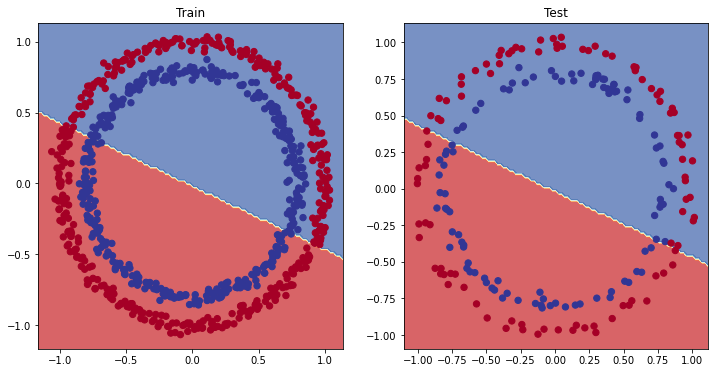

In [28]:
# plot decision boundary of the model
from helper_functions import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, Y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, Y_test)


# Improving a model (from a model perspective)


* Add more layers - give the model more chance to learn about patterns in the data
* Add more hidden units - go from 5 hidden units tp 10 hidden units
* Fit for longer
* Changing the activation function
* Change the laerning rate
* Change the loss function  

These options are a;; from a model's perspective because they deal directly with the model , rather than the data

And because these options are all values we (as machine learning engineers and data scientists) can change , they are referred as **hyperparameters**

In [29]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features=10)
    self.layer_3 = nn.Linear(in_features = 10, out_features=1)

  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()
# Create an optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(), lr =0.1)

In [31]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# train for longer
epoc = 1000

# Put data on the target device
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

for epoch in range(epochs):
  # Training
  model_1.train()
  # forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> prediction labels

  # Calculate the loss /acc
  loss = loss_fn(y_logits, Y_train)
  acc = accuracy_fn(y_true = Y_train, y_pred = y_pred)

  # optimizer zero grad
  optimizer.zero_grad()

  # loss backwards (back propagation)
  loss.backward()

  # optimizer step (gradient descent)
  optimizer.step()

  # testing 
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate loss 
    test_loss = loss_fn(test_logits, Y_test)
    test_acc = accuracy_fn(y_true = Y_test, y_pred = test_pred)

  # Print out what's happening'
  if epoch%100==0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc: .2f}")


Epoch: 0 | Loss: 0.69396, Acc: 50.88 | Test loss: 0.69261, Test acc:  51.00
Epoch: 100 | Loss: 0.69305, Acc: 50.38 | Test loss: 0.69379, Test acc:  48.00
Epoch: 200 | Loss: 0.69299, Acc: 51.12 | Test loss: 0.69437, Test acc:  46.00
Epoch: 300 | Loss: 0.69298, Acc: 51.62 | Test loss: 0.69458, Test acc:  45.00
Epoch: 400 | Loss: 0.69298, Acc: 51.12 | Test loss: 0.69465, Test acc:  46.00
Epoch: 500 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69467, Test acc:  46.00
Epoch: 600 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc:  46.00
Epoch: 700 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc:  46.00
Epoch: 800 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc:  46.00
Epoch: 900 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc:  46.00


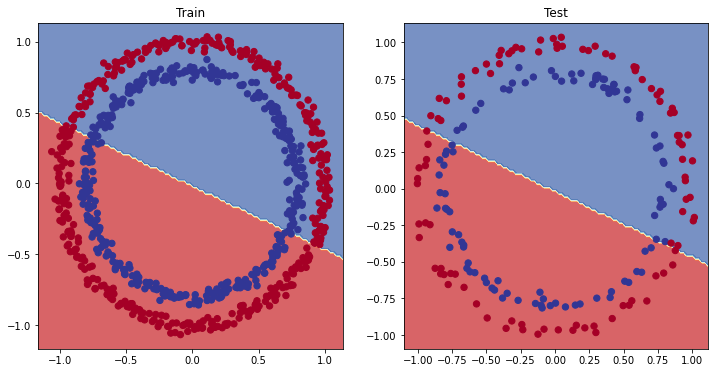

In [32]:
# plot decision boundary of the model
from helper_functions import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, Y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, Y_test)

In [33]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features =1 , out_features = 10),
    nn.Linear(in_features =10, out_features = 10),
    nn.Linear(in_features = 10, out_features = 1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
# Loass and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.1)

Recreatung non-linear data (red and blue circles)

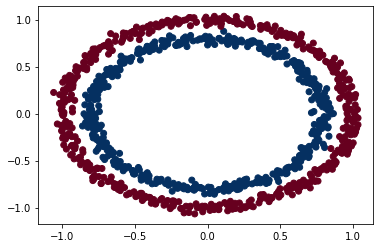

In [35]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [36]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

# Build a model with non-linear activation function

Linear = straight linear
Non-Linaer = non-straight lineas

Artificial neural newroks are a large combination of linear (straight) and non-straight(non-linear) functions which are potentially able to find pattern in the data

In [37]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [38]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

# Training a model with non-linearity

In [39]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69541, Accuracy: 50.00% | Test Loss: 0.69584, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69015, Accuracy: 53.12% | Test Loss: 0.69060, Test Accuracy: 50.00%
Epoch: 200 | Loss: 0.68791, Accuracy: 54.25% | Test Loss: 0.68762, Test Accuracy: 54.50%
Epoch: 300 | Loss: 0.68421, Accuracy: 58.88% | Test Loss: 0.68343, Test Accuracy: 59.00%
Epoch: 400 | Loss: 0.67898, Accuracy: 62.25% | Test Loss: 0.67833, Test Accuracy: 64.50%
Epoch: 500 | Loss: 0.67115, Accuracy: 64.00% | Test Loss: 0.67120, Test Accuracy: 67.50%
Epoch: 600 | Loss: 0.65742, Accuracy: 72.00% | Test Loss: 0.65936, Test Accuracy: 69.50%
Epoch: 700 | Loss: 0.63149, Accuracy: 85.12% | Test Loss: 0.63744, Test Accuracy: 84.00%
Epoch: 800 | Loss: 0.58168, Accuracy: 91.88% | Test Loss: 0.59477, Test Accuracy: 91.50%
Epoch: 900 | Loss: 0.49246, Accuracy: 93.88% | Test Loss: 0.51760, Test Accuracy: 93.50%


In [40]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

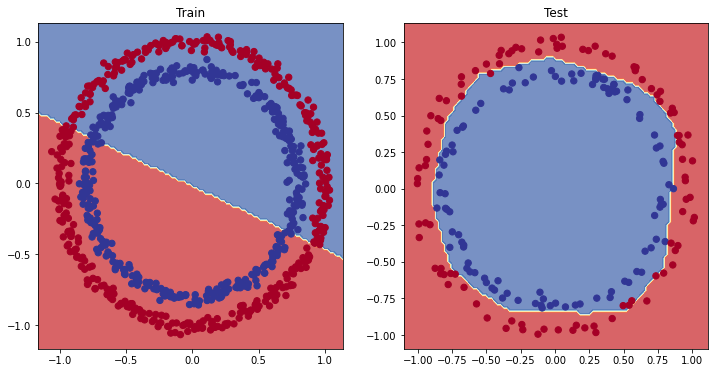

In [41]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

# Putting things together by building multi class Pytorch mdoel

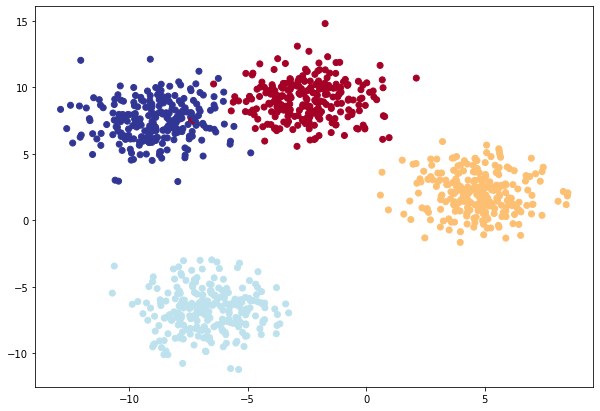

In [42]:
# import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# SEy the hyperparameters for daya creation
NUM_CLASSES = 4
MUM_FEATURES = 2
RANDOM_SEED = 42

# Create multi class data
X_blob, Y_blob = make_blobs(n_samples = 1000, n_features =MUM_FEATURES, centers = NUM_CLASSES, cluster_std = 1.5, random_state = RANDOM_SEED)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
Y_blob = torch.from_numpy(Y_blob).type(torch.float)

# Split into train and test 
X_blob_train, X_blob_test, Y_blob_train, Y_blob_test = train_test_split(X_blob, Y_blob, test_size = 0.2, random_state = RANDOM_SEED)

# Plot the data 
plt.figure(figsize = (10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c = Y_blob, cmap= plt.cm.RdYlBu)

In [45]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=MUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [46]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [47]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.6226, -0.4992,  0.3042, -0.2222],
        [ 0.6736, -1.1873,  0.1842, -0.6871],
        [ 0.2130, -0.9997,  0.3891, -1.0923],
        [ 0.4027, -0.7745,  0.4512, -0.8176],
        [ 0.3791, -1.2052,  0.0704, -0.7173]], device='cuda:0',
       grad_fn=<SliceBackward0>)

# A few more classification metrics ...

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1- score
* Confusion metrix
* classification report